In [1]:
import pyvisa as visa
import time
import numpy as np
import matplotlib.pyplot as plt

from Oscilloscope import *
from PSU_6705 import *
from ElectronicLoad import *
#List all resources
rm = visa.ResourceManager()
print("Connected devices:\n", rm.list_resources())

D:\Jupiter\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Connected devices:
 ('USB0::0x0699::0x0401::C020996::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL6::INSTR', 'ASRL8::INSTR', 'ASRL9::INSTR', 'ASRL12::INSTR')


In [2]:
from docx import Document
from docx.shared import Inches
from datetime import datetime
test_name='Power Test'
device_under_test='Agrregator'
current_date = datetime.now()
test_date = current_date.strftime("%Y-%m-%d-%H%M")

doc = Document()
doc.add_heading(f'{test_name}',level=1)
doc.add_paragraph(f'Time: {test_date}\nDUT: {device_under_test}')

In [3]:
doc.save(f'{device_under_test} {test_name} {test_date}.docx')

# Set up 


In [4]:
doc.add_heading(f'Set up',level=2)

In [5]:
doc.add_heading(f'Load',level=3)

In [6]:
#Load set-up
load_path='COM9'
load  = ElectronicLoad(load_path)
#load.read_termination='\n'
load.write(":INPut OFF")
load.write(":VOLT:UPPer 5V")
load.write(":CURR:UPPer 1A")
load.write(":POW:UPPer 6W")
load.write(":FUNC CC")
load_idn=load.query("*IDN?")
doc.add_paragraph(f'idn:{load_idn}\n path:{load_path}\n')

TENMA 72-13210 V3.21 SN:00018436 connected


In [7]:
doc.add_heading(f'PSU',level=3)

In [8]:
#PSU set-up
psu_path='COM11'
psu= PSU_6705(psu_path)
#psu.switch_output(0)
psu.off()
psu.set_value(1,'v',12) #CH1 24V
psu.set_value(1,'c',1) #CH1 1A
psu.status_inquire()

psu_idn=psu.get_IDN()
doc.add_paragraph(f'idn:{psu_idn}\n path:{psu_path}\n')

DC Power Supply 6705 at serial COM11 is open


In [9]:
doc.add_heading(f'Oscilloscope',level=3)

In [10]:
#Oscilloscope set-up
osc_path='USB0::0x0699::0x0401::C020996::INSTR'

osc= Oscilloscope(rm,'USB0::0x0699::0x0401::C020996::INSTR')
osc_idn=osc.query("*IDN?")
#osc.scope.timeout=10000
#osc.write("*CAL?")



TEKTRONIX,DPO4034,C020996,CF:91.1CT FV:v2.30 DPO4COMP:V1.00 DPO4EMBD:V1.00  Connected


In [11]:
#osc.write("*CAL?")


In [12]:
osc.write("ACQUIRE:MODE AVERAGE")

In [13]:

osc.write("SELECT:CH1 ON")
osc.set_coupling("1","DC")
osc.add_measurement(1,1,"RMS")


osc.write("SELECT:CH2 ON")
osc.set_coupling("2","DC")
osc.add_measurement("2","2","RMS")
doc.add_paragraph(f'idn:{osc_idn}\n path:{osc_path}\n')

In [14]:
doc.save(f'{device_under_test} {test_name} {test_date}.docx')

In [15]:
#power on test instruments
load.on()
psu.on()
time.sleep(3)

In [16]:
#osc.auto_y_scale(1)
#osc.auto_y_scale(2)
#osc.set_t_scale(0.01)

In [17]:
osc.write('CH1:PROBE:GAIN 0.1')
osc.write('CH2:PROBE:GAIN 0.1')
osc.set_y_scale(1,0.5)
osc.set_offset(1,10)
osc.write('CH1:POSITION -4') 
osc.set_y_scale(2,0.5)
osc.set_offset(2,5)
#osc.write('CH1:POSITION -4') 
osc.set_t_scale(0.01)

write this function!!!


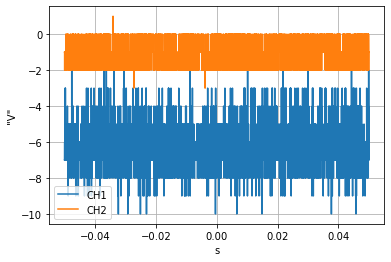

In [18]:
osc.get_waveform_all()

# Effiency vs load current

In [19]:
doc.add_heading(f'Effiency vs load current',level=2)

In [20]:
#Efficiency vs load current
start_load=0.01 # Unit A
end_load=1
num=10
inter_p = np.logspace(np.log10(start_load), np.log10(end_load), num)

rounded_number =np.round(inter_p, 4)
#print(rounded_number)

vo_list=[]
co_list=[]
vi_list=[]
ci_list=[]
#print("WORKING...")
for i in range (num):
    load.write(f":CURRent {rounded_number[i]}A" )
    time.sleep(2)
    
    output_v=osc.get_measurement(2)
    #output_v=load.get_current_voltage()
    output_c=load.get_current_current()
    print(f"output {output_v} {output_c}")
    vo_list.append(output_v)
    #vo_list.append(float(output_v[:-1]))
    co_list.append(float(output_c))
    
    input_status=psu.status_inquire()
    #input_v=input_status.get('ch1_out_voltage')
    input_v=osc.get_measurement(1)
    input_c=input_status.get('ch1_out_current')
    print(f"input {input_v} {input_c}")
    vi_list.append(input_v)
    ci_list.append(input_c)
    
vo_array = np.array(vo_list)
co_array = np.array(co_list)
vi_array = np.array(vi_list)
ci_array = np.array(ci_list)

#vo_array=vo_array-0.5
#vi_array=vi_array-0.2

output 5.04 0.0099
input 11.9145 0.005
output 5.0822 0.0165
input 11.94 0.008
output 5.1067 0.0276
input 11.9569 0.013
output 5.1268 0.0464
input 11.9661 0.022
output 5.1388 0.0772
input 11.9731 0.037
output 5.1444 0.129
input 11.9758 0.061
output 5.1483 0.2151
input 11.9753 0.102
output 5.1476 0.3592
input 11.9707 0.17
output 5.1349 0.5992
input 11.9594 0.281
output 5.0935 0.9998
input 11.9391 0.456


In [22]:
po_array = vo_array * co_array
pi_array = vi_array * ci_array
print(po_array)
print(pi_array)
efficiency=po_array/pi_array *100
print(efficiency)

[0.049896   0.0838563  0.14094492 0.23788352 0.39671536 0.6636276
 1.10739933 1.84901792 3.07683208 5.0924813 ]
[0.0595725 0.09552   0.1554397 0.2632542 0.4430047 0.7305238 1.2214806
 2.035019  3.3605914 5.4442296]
[83.75676696 87.78925879 90.674982   90.36266848 89.55104991 90.84270766
 90.66041082 90.85998313 91.55626834 93.53906198]


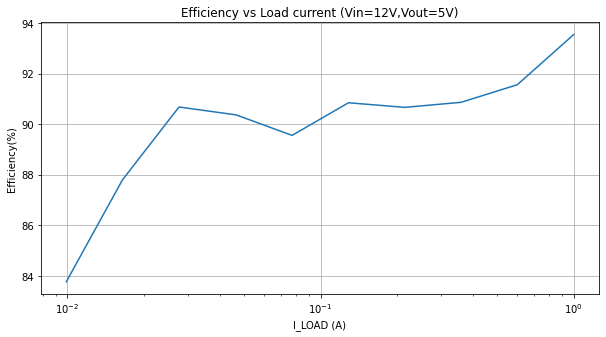

In [23]:

plt.figure(figsize=(10, 5))
plt.plot(co_list, efficiency)
plt.xscale('log')
plt.grid(True)


plt.title('Efficiency vs Load current (Vin=12V,Vout=5V)')
plt.ylabel('Efficiency(%)')
plt.xlabel('I_LOAD (A)')
#plt.xticks()
plt.savefig('Efficiency vs Load current.png')


In [24]:
doc.add_picture('Efficiency vs Load current.png', width=Inches(4))
doc.save(f'{device_under_test} {test_name} {test_date}.docx')

# load_regulation

In [25]:
doc.add_heading(f'Load regulation',level=2)

In [26]:
#load_regulation

v_list=[]
c_list=[]
print("WORKING...")
for i in range (num):
    #print(rounded_number[i])
    #print(":CURRent",f"{rounded_number[i]}" ,"A")
    load.write(f":CURRent {rounded_number[i]}A" )
    time.sleep(2)
    #print(load.get_current_voltage(),load.get_current_current())
    v_list.append(load.get_current_voltage())
    c_list.append(load.get_current_current())

print(v_list,c_list)


WORKING...
[5.1518, 5.1517, 5.1497, 5.1451, 5.1358, 5.1247, 5.1112, 5.0818, 5.0045, 4.84] [0.0098, 0.0166, 0.0276, 0.0462, 0.0772, 0.129, 0.2151, 0.3592, 0.5992, 0.9998]


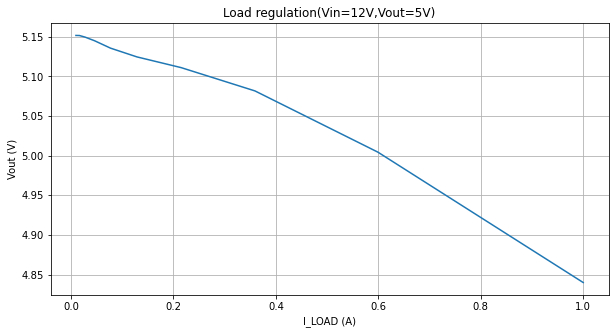

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(c_list, v_list)
plt.grid(True)

# 添加标题和标签
plt.title('Load regulation(Vin=12V,Vout=5V)')
plt.ylabel('Vout (V)')
plt.xlabel('I_LOAD (A)')
plt.savefig('Load regulation.png')


In [28]:
doc.add_picture('Load regulation.png', width=Inches(4))
doc.save(f'{device_under_test} {test_name} {test_date}.docx')

# AC Related Test

In [29]:
doc.add_heading(f'AC Related Test',level=2)

In [30]:
osc.write("SELECT:CH3 ON")
osc.write("TRIGGER:A:EDGE:SOURCE CH3")
osc.write("TRIGGER:A:EDGE:SLOPE FALL")
osc.write("TRIGGER:A:EDGE:COUPLING HFREJ")#{DC|HFRej|LFRej|NOISErej}
osc.set_coupling(3,"AC")
osc.write("CH3:BANDWIDTH TWENTY")#{TWEnty|TWOfifty|FULl|<NR3>}
osc.add_measurement(3,3,"PK2Pk")
osc.add_measurement(4,3,"PKPKNoise")
osc.add_measurement(5,3,"FREQUENCY")

In [31]:
osc.auto_scale(3)

# fsw vs load current

In [32]:
doc.add_heading(f'fsw vs load current',level=2)

In [34]:
#fsw vs load current

#Efficiency vs load current
start_load=0.1 # Unit A
end_load=1
num=5
inter_p = np.logspace(np.log10(start_load), np.log10(end_load), num)

rounded_number =np.round(inter_p, 4)
#print(rounded_number)

fo_list=[]
co_list=[]

load.on()
for i in range (num):
    load.write(f":CURRent {rounded_number[i]}A")
    time.sleep(2)
    osc.auto_scale(3,False)
    input("hand scale")
    #output_f=osc.get_measurement(5)
    output_f=osc.get_frequency(3)
    #print(osc.get_frequency(3))
    output_c=load.get_current_current()
    print(f"output {output_f} {output_c}")
    fo_list.append(float(output_f))
    co_list.append(float(output_c))
    input("enter")
      




hand scale
180482.2
output 64932.2 0.0998
enter
hand scale
96246.6
output 97220.7 0.1776
enter
hand scale
170389.3
output 170544.9 0.3159
enter
hand scale
300216.7
output 299967.7 0.562
enter
hand scale
509071.4
output 511037.9 0.9998
enter
[64932.2, 97220.7, 170544.9, 299967.7, 511037.9] [0.0998, 0.1776, 0.3159, 0.562, 0.9998]


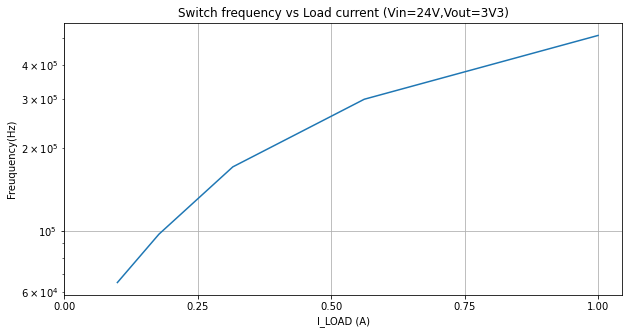

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(co_list, fo_list)
plt.grid(True)
plt.yscale('log')


max_frequency = max(fo_list)

y_tick_values = np.logspace(0, np.log10(max_frequency), 10)

#plt.yticks(y_tick_values, y_tick_values.astype(int))
x_tick_values = np.linspace(0, max(co_list), 5)
plt.xticks(x_tick_values, ['{:.2f}'.format(value) for value in x_tick_values])
#plt.scale("linear")
#plt.xticks(co_list, ['{:.2f}'.format(co) for co in co_list])
plt.title('Switch frequency vs Load current (Vin=24V,Vout=3V3)')
plt.ylabel('Freuquency(Hz)')
plt.xlabel('I_LOAD (A)')

#plt.show()
plt.savefig('Switch frequency vs Load current.png')


In [36]:
doc.add_picture('Switch frequency vs Load current.png', width=Inches(4))
doc.save(f'{device_under_test} {test_name} {test_date}.docx')

# Ripple 

In [41]:
osc.write("ACQUIRE:MODE SAMPLE")


Vpp：0.11V


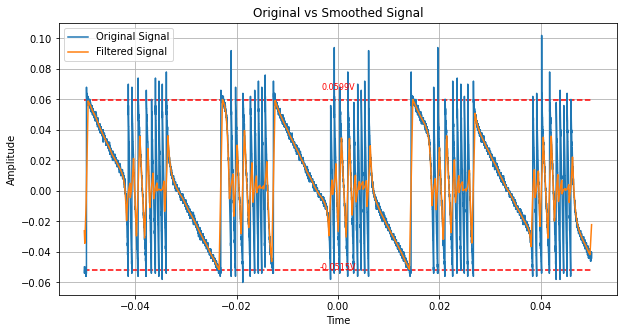

output 0.11145454545454546 0.0

Vpp：0.11V


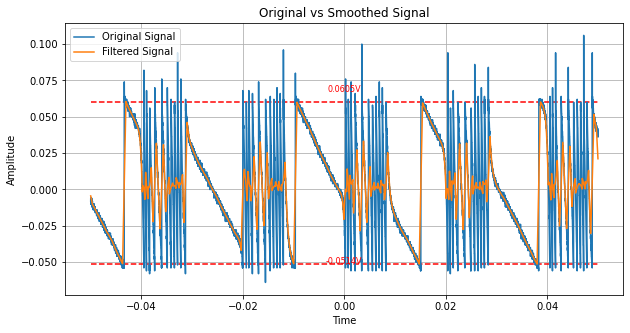

output 0.11187878787878788 0.0002

Vpp：0.11V


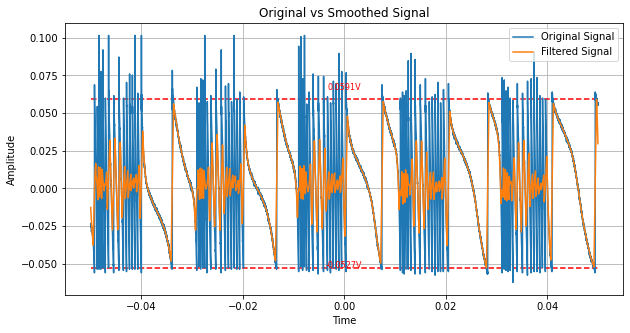

output 0.111824 0.0006

Vpp：0.10V


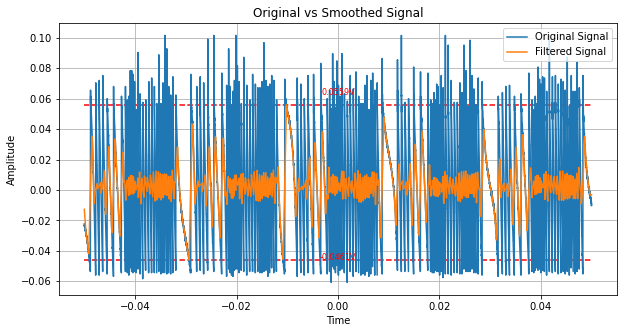

output 0.10204848484848486 0.002

Vpp：0.11V


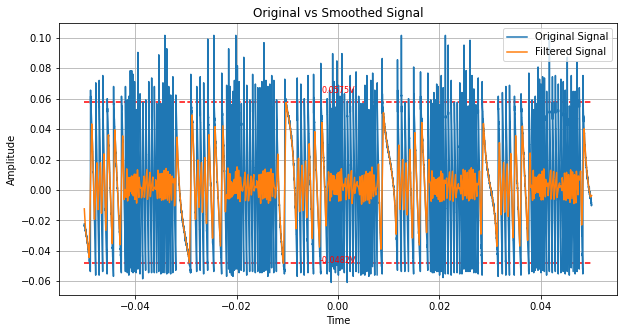

output 0.10568 0.0058

Vpp：0.11V


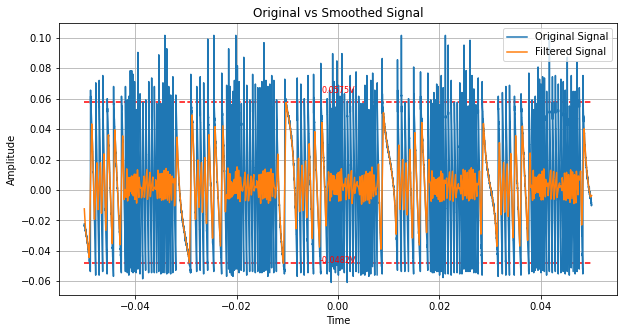

output 0.10568 0.0166

Vpp：0.16V


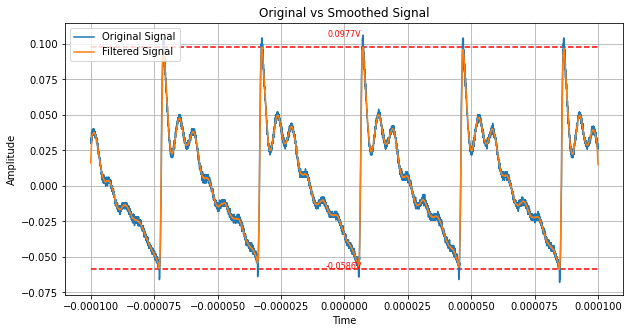

output 0.15635 0.0463

Vpp：0.14V


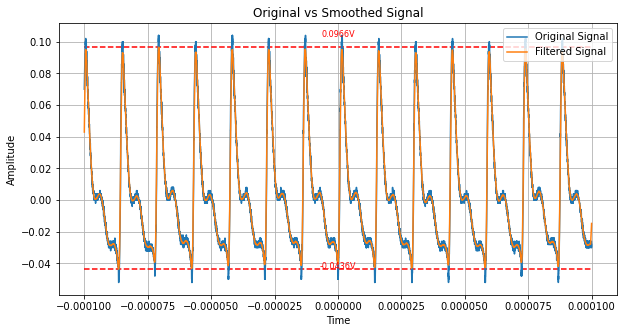

output 0.14015 0.1289

Vpp：0.14V


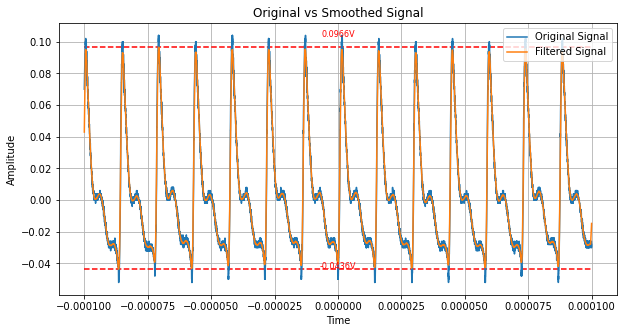

output 0.14015 0.3592

Vpp：0.14V


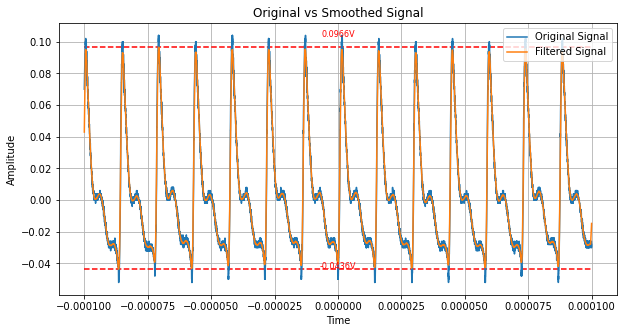

output 0.14015 0.9998
Unit for frequency :"V"


In [43]:
#ripple test


start_load=0.0001 # Unit A
end_load=1
num=10
inter_p = np.logspace(np.log10(start_load), np.log10(end_load), num)

rounded_number =np.round(inter_p, 4)
#print(rounded_number)

vo_list=[]
co_list=[]

for i in range (num):
    load.write(f":CURRent {rounded_number[i]}A" )
    time.sleep(2)
    osc.auto_scale(3,False)
    input("")
    output_c=load.get_current_current()
    
    output_v=osc.measure_ripple(3)
    print(f"output {output_v} {output_c}")
    vo_list.append(float(output_v))
    co_list.append(float(output_c))
    
    w,t=osc.get_waveform_data(3)
    data = np.vstack((w, t)).T
    name=f"{output_c}data.txt"
    np.savetxt(name, data)
#print(fo_list,co_list)

#print(f"Unit for frequency :{osc.query(':MEASUREMENT:MEAS3:UNIT?')}")

#osc.get_waveform(3)

#plt.plot(co_list, vo_list)
#plt.grid(True)


#plt.title('Voltage ripple vs Load current (Vin=24V,Vout=3V3)')
#plt.ylabel('Vpp(V)')
#plt.xlabel('I_LOAD (A)')

#plt.show()

# Power on sequence

In [327]:
osc.write("SELECT:CH3 OFF")
osc.set_offset(1,0)
osc.write('CH1:POSITION 0') 

osc.write("TRIGGER:A:EDGE:SOURCE CH1")
osc.write("TRIGGER:A:EDGE:SLOPE RISE")

osc.set_offset(2,0)
osc.set_t_scale(0.02)
#osc.auto_y_scale(1)
#osc.auto_y_scale(2)
psu.off()
load.off()


In [328]:
osc.write("ACQuire:STOPAfter SEQUENCE")
osc.write("ACQuire:STATE RUN")

In [329]:
psu.off()

In [330]:
psu.on()

write this function!!!


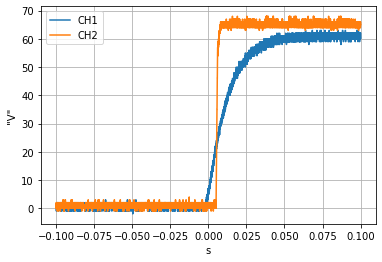

In [331]:
osc.get_waveform_all()

In [332]:
#osc.set_t_scale(0.02)
osc.write("TRIGGER:A:EDGE:SLOPE FALL")
osc.write("ACQuire:STOPAfter SEQUENCE")
osc.write("ACQuire:STATE RUN")

In [333]:
osc.set_t_scale(1)
time.sleep(1)
psu.off()
time.sleep(10)

In [334]:
psu.on()

In [335]:
psu.off()

write this function!!!


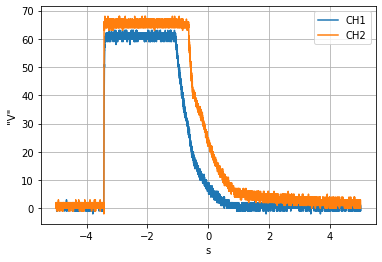

In [336]:
osc.get_waveform_all()

In [288]:

psu.off()
#osc.get_waveform_all()

In [ ]:
osc.write("TRIGGER:A:EDGE:SOURCE CH1")
osc.write("TRIGGER:A:EDGE:COUPLING DC")
osc.write("TRIGGER:A:EDGE:SLOPE RISE")
osc.write("AcQUIRE:STATE 0")
osc.write("ACQuire:STOPAfter RUNSTOP")
osc.write("TRIGGER:A:LEVEL 5")
osc.write("TRIGGER:A:MODE NORMAL")
osc.write("AcQUIRE:STATE RUN")

In [ ]:
osc.write("AcQUIRE:STATE ON")

In [306]:
osc.query("ACquire:STATE?")

'0'

In [ ]:
osc.write("HORizontal:delay:time 0.02")
osc.write("HORizontal:scale 0.02")
osc.write("TRIGGER:A:EDGE:SLOPE RISE")
psu.off()
#osc.write("AcQUIRE:STATE 1")
time.sleep(1)
#osc.get_waveform_all()
psu.on()
time.sleep(3)
osc.get_waveform_all()

In [ ]:
#osc.write("HORizontal:scale 0.1")
#osc.write("TRIGGER:A:EDGE:SLOPE FALL")
osc.write("AcQUIRE:STATE RUN")

In [ ]:
osc.write("TRIGGER:A:EDGE:SLOPE FALL")
osc.write("HORizontal:delay:time 0.1")
osc.write("AcQUIRE:STATE STOP")
osc.write("HORizontal:scale 0.1")
osc.write("AcQUIRE:STATE RUN")
psu.on()
time.sleep(1)


#osc.write("AcQUIRE:STATE 1")
psu.off()

time.sleep(1)
osc.get_waveform_all()

In [ ]:
osc.get_waveform(1)

In [ ]:
osc.get_waveform_all()

In [ ]:
psu.off()

In [ ]:
osc.get_waveform(1)
osc.get_waveform_all()

In [ ]:


#Load regulation test
#DCPS OUT1 to P1
#DCPS 24V1A
#Osc TP5'TP6(+3V3)
#electronic load TP5'TP6(+3V3)
#electronic load CC mode

#Ripple test
#CH1 +24 DC
#CH2 +3v3 DC
#Ch3 +3v3 AC




In [ ]:
# 1.2.1 24V->3V3

###PSU set-up
#psu=PSU_6705('COM5')
#psu.switch_output(0)
#psu.set_value(1,'v',24)
#psu.set_value(1,'c',1)

###Oscilloscope set-up
#osc= Oscilloscope(rm,'USB0::0x0699::0x0401::C020996::INSTR')
#osc.scope.timeout=10000
#osc.set_coupling("1","DC")
#osc.add_measurement("1","CH1","RMS")
#osc.write("SELECT:CH2 ON")
#osc.set_coupling("2","DC")
#osc.add_measurement("2","CH2","RMS")
#osc.write("SELECT:CH3 ON")
#osc.set_coupling("3","AC")
#osc.add_measurement("3","CH3","PK2Pk")
#osc.add_measurement("4","CH3","PKPKNoise")